# Example MERFISH Data
Here is an example on how to run ISTDECO on multiplexed error-robust fluorescent in situ hybridization (MERFISH) images.
The protocols and data analysis are described in this [publication](https://science.sciencemag.org/content/348/6233/aaa6090). The data can be downloaded with (https://github.com/spacetx/starfish). We start by downloading the data using [Starfish].


## First install STARFISH

In [1]:
# !pip install starfish[napari]

## Get the data
Here we follow the STARFISH [tutorial](https://spacetx-starfish.readthedocs.io/en/latest/gallery/pipelines/merfish_pipeline.html#sphx-glr-gallery-pipelines-merfish-pipeline-py) to download and preprocess the data.

In [2]:
from starfish import data
from starfish import FieldOfView
from starfish.image import Filter
from starfish.types import Axes
from copy import deepcopy

# Download the data
experiment = data.MERFISH(use_test_data=False)
image_data = experiment.fov().get_image(FieldOfView.PRIMARY_IMAGES)

# Preprocess
ghp = Filter.GaussianHighPass(sigma=3)
ghp.run(image_data, verbose=True, in_place=True)
            
# Scale the rounds and channels
scale_factors = {
    (t[Axes.ROUND], t[Axes.CH]): t['scale_factor']
    for t in experiment.extras['scale_factors']
}
for selector in image_data._iter_axes():
    data = image_data.get_slice(selector)[0]
    scaled = data / scale_factors[selector[Axes.ROUND.value], selector[Axes.CH.value]]
    image_data.set_slice(selector, scaled, [Axes.ZPLANE])

100%|██████████| 16/16 [00:00<00:00, 897.49it/s]


We need to set appropriate variables before we can run ISTDECO.

#### Notation
- $r$ Number of imaging rounds
- $c$ Number of channels
- $m$ Number of codes in codebook
- $h$ Image height
- $w$ Image width
- $\sigma_{psf}$ Standard deviation of the Gaussians describing the spatial shape of the spots
- $Y \in \mathbb{R}_+^{r\times c \times h \times w}$ Image data
- $D \in \mathbb{R}_+^{m \times r\times c}$ Codebook (Combinatorial labels)
- $b \in \mathbb{R}_+^{m \times r\times c}$ Background

In [3]:
r = 8
c = 2
m = experiment.codebook.shape[0]
h = 512
w = 512
sigma = 1.75
Y = image_data.xarray.data[:,:,0,0:h,0:w].squeeze()
D = experiment.codebook.data
b = 1e-8            # Image are preprocessed so we don't need to set the background. 
                    #Keep it nonzero to avoid divisions by zero.
target_names = experiment.codebook.target.data

print(f'Image data shape: {Y.shape}. Codebook shape: {D.shape}')

Image data shape: (8, 2, 512, 512). Codebook shape: (140, 8, 2)


## Plot the image data

(-0.5, 511.5, 511.5, -0.5)

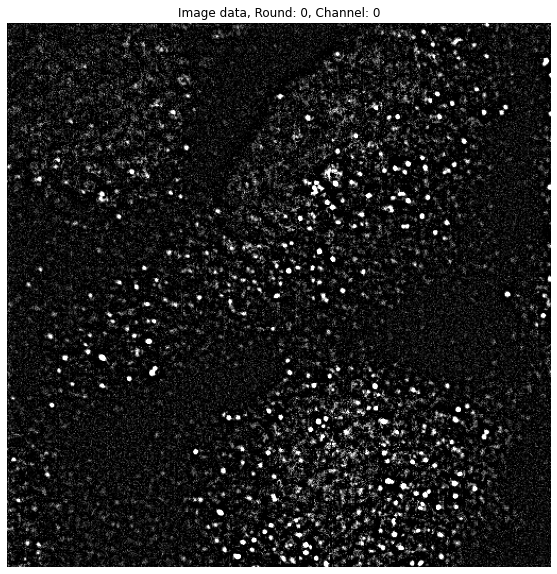

In [4]:
import numpy as np
import matplotlib.pyplot as plt

single_plane = Y[0,0]

plt.figure(figsize=(10, 10))
plt.imshow(single_plane, cmap='gray', clim=list(np.percentile(single_plane, [5, 99])))
plt.title('Image data, Round: 0, Channel: 0')
plt.axis('off')

## Run ISTDECO
Now we are ready to run ISTDECO! 

In [5]:
from istdeco import ISTDeco

# Create the model
model = ISTDeco(Y, D, (sigma, sigma))

# OPTIONAL (we can accelerate computations if a GPU is available)
model.to('cuda')

# Deconvolve the data
# Here we use 50 iterations. Usually between 20-300 iterations is fine.
X, _, _ = model.run(niter=50)

# Colour limit (for plotting)
clim = [0, np.sort(X.ravel())[-1000]]

## Plot the deconvolved images
Change `gene_id` to show a different gene

(-0.5, 511.5, 511.5, -0.5)

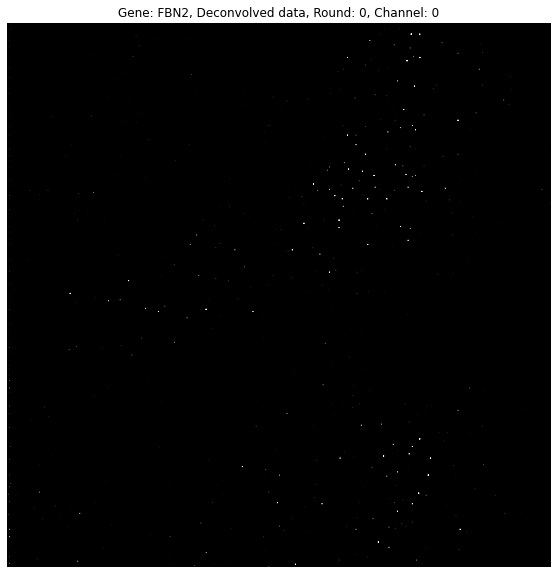

In [6]:
gene_id = 137
plt.figure(figsize=(10, 10))
plt.imshow(X[gene_id], cmap='gray', clim=clim)
plt.title(f'Gene: {target_names[gene_id]}, Deconvolved data, Round: 0, Channel: 0')
plt.axis('off')

## Decode the entire image
Next we decode the entire field of view.

In [7]:
# Sadly 2048 x 2048 images are a bit too large for my laptop,
# hence we tile the image
ntiles = (4,4)
tile_shape = (512, 512)

# Dataframe to dump result in
import pandas as pd
results = pd.DataFrame()

# Only pick barcodes with intensity larger than this
# 99th percentile might seem larger. Recall that data
# is sparse; even sparse once deconvolved and unmixed.
tau = np.percentile(Y,99)

# Loop over tiles
for i in range(ntiles[0]):
    for j in range(ntiles[1]):
        
        # Pick a tile
        # Ideally you should use overlapping tiles
        slicey = slice(i*tile_shape[0], (i+1)*tile_shape[0])
        slicex = slice(j*tile_shape[1], (j+1)*tile_shape[1])
        tile = image_data.xarray.data[:,:,0,slicey, slicex]
        
        
        model = ISTDeco(tile, D, (sigma, sigma), b=b).to('cuda')
        X, Q, loss = model.run(niter=35, suppress_radius=1)
        
        # Get codes
        code_id, y, x = np.where(np.logical_and(X>tau,Q>0.2))
        
        intensity = X[code_id, y, x]
        quality = Q[code_id, y, x]

        # Store in dataframe
        df = pd.DataFrame(data={
                'x': x.astype('float') + j*tile_shape[1], 
                'y': y.astype('float') + i*tile_shape[0],
                'target_id': code_id + 1,
                'intensity': intensity, 
                'quality': quality,
                'target_name': target_names[code_id].ravel()
        })
        
        results = results.append(df)
        
# Dump in a .csv
results.to_csv('../../Results/MERFISH/results.csv')

# Post processing
The codebook contained 10 non-targeted barcodes (named blank-1, ... blank-10). We can use these as a proxy for false-positives. Ideally we would filter the barcodes such that very few (or none) non-targeted barcodes are detected.

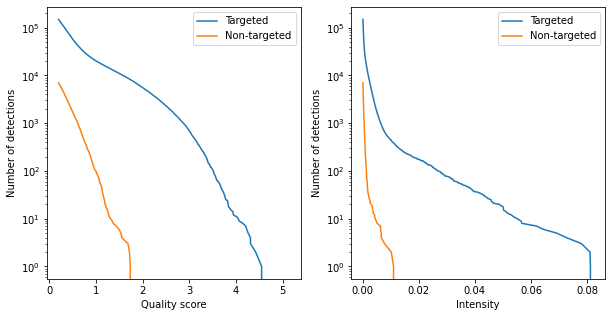

In [8]:
# Name of nontargeted genes
non_targeted_names = [ f'Blank-{i+1}' for i in range(10)]

# Load the raw decoding from the csv
results = pd.read_csv('../../Results/MERFISH/results.csv')


# Thera are some artifacts near the edges
# Let's remove all detections from the edges. 
fov = [40,40,2008,2008]
results = results[ (results['x'] >= fov[0]) & (results['x'] <= fov[2])  & (results['y'] >= fov[1]) & (results['y'] <= fov[3])]


# Split the dataframe into targeted and non targeted detections
ntargeted = results[results['target_name'].isin(non_targeted_names)]
targeted = results[~results['target_name'].isin(non_targeted_names)]

# Sort data by intensity and quality
ntargeted_quality = ntargeted.sort_values('quality',ascending=False)
ntargeted_intensity = ntargeted.sort_values('intensity',ascending=False)
targeted_quality = targeted.sort_values('quality',ascending=False)
targeted_intensity = targeted.sort_values('intensity',ascending=False)

# Plot curves
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.semilogy(targeted_quality['quality'].to_numpy(), \
             np.arange(0,targeted_quality.shape[0]), \
             label='Targeted')

plt.semilogy(ntargeted_quality['quality'].to_numpy(), \
             np.arange(0,ntargeted_quality.shape[0]), \
             label='Non-targeted')
plt.xlabel('Quality score')
plt.ylabel('Number of detections')
plt.legend()

plt.subplot(122)
plt.semilogy(targeted_intensity['intensity'].to_numpy(), \
             np.arange(0,targeted_quality.shape[0]), \
             label='Targeted')

plt.semilogy(ntargeted_intensity['intensity'].to_numpy(), \
             np.arange(0,ntargeted_quality.shape[0]), \
             label='Non-targeted')
plt.xlabel('Intensity')
plt.ylabel('Number of detections')
plt.legend()

Setting a quality threshold to approximately 1.8 results in no nontargeted detections. 

## Compare with benchmark
Finally, we compare our decoding with the benchmark (available using Starfish). 

Text(0.5, 1.0, 'Count correlation = 0.9868889422818707')

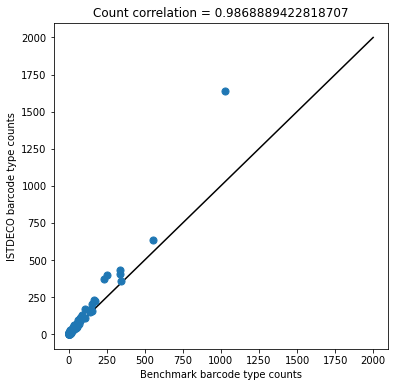

In [9]:
# Example taken from:
# https://spacetx-starfish.readthedocs.io/en/latest/gallery/pipelines/merfish_pipeline.html?highlight=merfish
# Load benchmark codes

# How many blank-genes (false positives) do we accept?
N_FP = 1

# Download benchmark
bench = pd.read_csv('https://d2nhj9g34unfro.cloudfront.net/MERFISH/benchmark_results.csv',\
                    dtype={'barcode': object})

# Filter benchmark
bench = bench[bench['area'] > 3]
thresh = bench[bench['gene'].isin(non_targeted_names)]['total_magnitude'].nlargest(N_FP).iloc[-1]
bench = bench[bench['total_magnitude'] > thresh]
benchmark_counts = bench.groupby('gene')['gene'].count()

result_counts = results[results['quality'] > ntargeted['quality'].nlargest(N_FP).iloc[-1]]\
    .groupby('target_name')['target_name']\
    .count()

tmp = pd.concat([result_counts, benchmark_counts], join='inner', axis=1).values
r = np.corrcoef(tmp[:, 1], tmp[:, 0])[0, 1]
x = np.linspace(50, 2000)
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(tmp[:, 1], tmp[:, 0], 50, zorder=2)
ax.plot(x, x, '-k', zorder=1)

plt.xlabel('Benchmark barcode type counts')
plt.ylabel('ISTDECO barcode type counts')
plt.title(f'Count correlation = {r}')